In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, lpSum,value
import numpy as np
from math import radians, sin, cos, sqrt, atan2


landslides_df = pd.read_excel(r"C:\Users\adity\Desktop\New folder\New folder (4)\New Microsoft Excel Worksheet.xlsx")



In [2]:
landslides_df

,landslide_category,landslide_size,country_name,country_code,admin_division_name,admin_division_population,longitude,latitude
0,landslide,medium,India,IN,Bengal,46427,88.278800,26.882600
1,landslide,medium,India,IN,Bengal,46427,88.314300,26.857200
2,landslide,medium,India,IN,Manipur,15118,94.482147,25.309863
3,landslide,medium,India,IN,Uttarakhand,32442,79.636700,29.733400
4,landslide,medium,India,IN,Kashmir,14711,74.333300,33.877800
...,...,...,...,...,...,...,...,...
1222,landslide,medium,India,IN,Bengal,123797,88.265221,27.043571
1223,landslide,small,India,IN,Himachal Pradesh,6690,76.670200,31.488100
1224,landslide,small,India,IN,Uttarakhand,25753,78.104500,30.452800
1225,landslide,medium,India,IN,Kerala,68000,77.069600,10.083800


C:\Users\adity\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


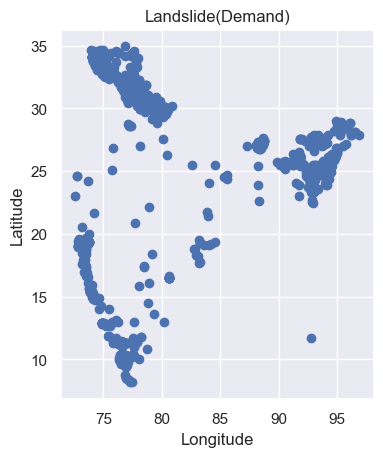

In [3]:
sns.set()
crs = {'init': 'epsg:4326'}  # Coordinate Reference System
geometry = [Point(xy) for xy in zip(landslides_df['longitude'], landslides_df['latitude'])]
landslides_gdf = gpd.GeoDataFrame(landslides_df, crs=crs, geometry=geometry)

# Plot the landslides on a map
landslides_gdf.plot()
plt.title('Landslide(Demand)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

C:\Users\adity\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


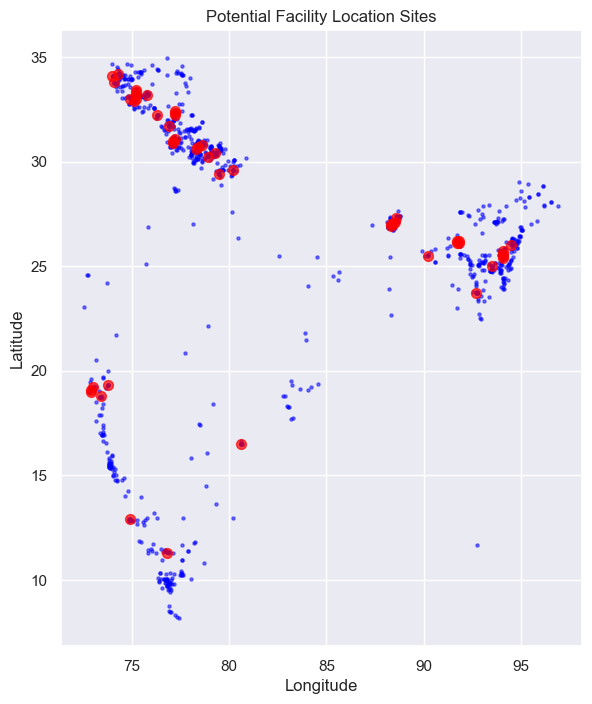

In [4]:
# Create a GeoDataFrame from the DataFrame
crs = {'init': 'epsg:4326'}  # Coordinate Reference System
geometry = [Point(xy) for xy in zip(landslides_df['longitude'], landslides_df['latitude'])]
landslides_gdf = gpd.GeoDataFrame(landslides_df, crs=crs, geometry=geometry)

# Calculate the density of landslides in each area
# For simplicity, let's use a grid-based approach to calculate density
# You can adjust the grid size based on your preference
grid_size = 0.1  # Adjust as needed
landslides_gdf['grid_longitude'] = landslides_gdf['longitude'].apply(lambda x: round(x / grid_size) * grid_size)
landslides_gdf['grid_latitude'] = landslides_gdf['latitude'].apply(lambda y: round(y / grid_size) * grid_size)
density = landslides_gdf.groupby(['grid_longitude', 'grid_latitude']).size().reset_index(name='count')

# Sort potential sites by the number of landslides in descending order
potential_sites = density.sort_values(by='count', ascending=False)

# Select top 300 potential sites with the highest density of landslides
pot_site = potential_sites.head(50)

# Plot the potential facility location sites
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all landslide points
landslides_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.5)

# Plot potential facility location sites
ax.scatter(pot_site['grid_longitude'], pot_site['grid_latitude'], color='red', s=50, alpha=0.7)

plt.title('Potential Facility Location Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [25]:
# Number of facilities to locate (p)
p = 15

In [6]:
pot_site.shape

(50, 3)

In [7]:
landslides_gdf.shape

(1227, 11)

In [22]:
# Initialize distance matrix
distance_matrix2 = np.zeros((landslides_gdf.shape[0], pot_site.shape[0]))

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371.01 * c  # Radius of the Earth in kilometers
    
    return int(distance)

# Convert GeoDataFrames to numpy arrays
landslides_coords = landslides_gdf[['latitude', 'longitude']].values
facility_coords_array = pot_site[['grid_latitude', 'grid_longitude']].values

# Fill distance matrix
for i, landslide_coords in enumerate(landslides_coords):
    for j, facility_coords in enumerate(facility_coords_array):
        distance_matrix2[i, j] = haversine_distance(landslide_coords[0], landslide_coords[1],
                                                    facility_coords[0], facility_coords[1])

# Print distance matrix (for demonstration)
print('Distance btw Demand and facility')
print(distance_matrix2)


Distance btw Demand and facility
[[1.439e+03 2.000e+00 1.444e+03 ... 1.389e+03 2.108e+03 1.564e+03]
 [1.444e+03 4.000e+00 1.449e+03 ... 1.394e+03 2.108e+03 1.568e+03]
 [2.061e+03 6.420e+02 2.065e+03 ... 2.009e+03 2.425e+03 2.179e+03]
 ...
 [4.100e+02 1.069e+03 4.180e+02 ... 3.750e+02 2.133e+03 5.480e+02]
 [2.577e+03 2.210e+03 2.588e+03 ... 2.573e+03 1.380e+02 2.696e+03]
 [1.780e+03 3.570e+02 1.784e+03 ... 1.729e+03 2.282e+03 1.900e+03]]


In [23]:
distance_matrix2.shape

(1227, 50)

In [24]:
len(distance_matrix2)

1227

In [11]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value
import numpy as np

def optimize(p, distance_matrix2, demand):
    # Define the problem
    n = len(distance_matrix2)  # Number of potential facility location sites
    m = len(distance_matrix2[0])  # Number of demand points

    # Define the problem
    problem = LpProblem("Maximal Median Problem", LpMinimize)

    # Decision variables
    x = LpVariable.dicts("x", range(n), cat='Binary')  # Binary variable for facility location
    y = LpVariable.dicts("y", [(i, j) for i in range(m) for j in range(n)], cat='Binary')  # Binary variable for demand coverage

    # Objective function: minimize total cost
    problem += lpSum(distance_matrix2[j][i] * demand[i] * y[(i, j)] for i in range(m) for j in range(n))

    # Constraints
    # Each demand must be served by exactly one facility
    for i in range(m):
        problem += lpSum(y[(i, j)] for j in range(n)) == 1

    # Exactly p facilities must be located
    problem += lpSum(x[j] for j in range(n)) == p

    # Demand can only be served by an open facility
    for i in range(m):
        for j in range(n):
            problem += y[(i, j)] <= x[j]

    # Solve the problem
    problem.solve()

    # Get the selected facility locations
    selected_facilities = [i for i in range(n) if x[i].varValue == 1]
    # Get the objective function value
    objective_value = value(problem.objective)
    print("Cost: ", objective_value)
    return selected_facilities

# Example usage
selected_facilities = optimize(p, distance_matrix2, np.array(pot_site))
print("Selected facility location sites:", selected_facilities)


C:\Users\adity\anaconda3\Lib\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Cost:  138805.8
Selected facility location sites: [201, 316, 327, 350, 354, 362, 413, 423, 513, 720, 762, 851, 913, 976, 1089]


## Formulation

In [36]:
df2 = pd.read_csv(r"C:\Users\adity\Desktop\New folder\New folder (4)\landslide data copy2.csv")

In [38]:

# List of indices
indices =[201, 316, 327, 350, 354, 362, 413, 423, 513, 720, 762, 851, 913, 976, 1089]

# Column name
column_name = 'location_description'  # For example, to retrieve values from column 'B'

# Retrieve values of the specified column for the given indices
values = df2.loc[indices, column_name]

a = np.array(values)


In [39]:
print('Selected Sites')
a

Selected Sites


array(['Ekvira Devi temple, Karla near Khandala',
       'Tuensang-Kohima rd, 3 km outside Tuensang, Nagaland',
       'Takdah, West Bengal', 'roads around Uttarkashi, Uttarakhand',
       'Ikou-Gangpijang road, near: Ikou, Saikul, and Gangpijang; Imphal India',
       'Kuthur – Huker Road Via Y Anner, Chessore, Nagaland',
       'Tuensang, Nagaland', 'Noklak-Tuensang road, Nagaland',
       'Srinigar-Ladakh highway',
       'Bhikona Village, Pokhri Block, Chamoli Village, Uttarakhand',
       'Pomendi Hill(?), Goa-Mumbai Konkan railway, both sides of Ratnagiri, Maharashtra',
       'Highway 53 at Tupul, Tamenglong district',
       'Kharghuli, Guwahati, Assam',
       'near Mohand, Dehradun-Delhi hwy, Uttar Pradesh',
       'Salem - Yercaud ghat road'], dtype=object)

## Objective function

In [55]:

def optimize(p, distance_matrix2, demand):
    # Define the problem
    n = len(distance_matrix2)  # Number of potential facility location sites
    m = len(distance_matrix2[0])  # Number of demand points

    # Define the problem
    problem = LpProblem("Maximal Median Problem", LpMinimize)

    # Decision variables
    x = LpVariable.dicts("x", range(n), cat='Binary')  # Binary variable for facility location
    y = LpVariable.dicts("y", [(i, j) for i in range(m) for j in range(n)], cat='Binary')  # Binary variable for demand coverage

    # Objective function: minimize total cost
    obj_expr = lpSum(distance_matrix2[j][i] * demand[i].astype(int) * y[(i, j)] for i in range(m) for j in range(n))
    problem += (obj_expr)

    # Print out each variable and coefficient in the objective function
    import re

    print("Objective Function: Min")
    for term in obj_expr.items():
        variable, coefficient = term
        # Extract indices from variable name using regular expressions
        indices = re.findall(r'\d+', variable.name)
        variable_index = ''.join(indices)
        print("{}*y{}".format(coefficient, variable_index), end=' + ')



# Example usage
selected_facilities = optimize(p, distance_matrix2, np.array(pot_site))


Objective Function: Min
185631.0*y00 + 186276.0*y01 + 265869.0*y02 + 73530.0*y03 + 14190.0*y04 + 55857.0*y05 + 54051.0*y06 + 58824.0*y07 + 49923.0*y08 + 64371.0*y09 + 38829.0*y010 + 54825.0*y011 + 53664.0*y012 + 80238.0*y013 + 320436.0*y014 + 256581.0*y015 + 258645.0*y016 + 16254.0*y017 + 255807.0*y018 + 294378.0*y019 + 81270.0*y020 + 270384.0*y021 + 61404.0*y022 + 58179.0*y023 + 2709.0*y024 + 645.0*y025 + 355653.0*y026 + 259548.0*y027 + 41022.0*y028 + 38829.0*y029 + 53664.0*y030 + 184083.0*y031 + 260838.0*y032 + 185889.0*y033 + 6966.0*y034 + 1935.0*y035 + 208335.0*y036 + 645.0*y037 + 249615.0*y038 + 903.0*y039 + 903.0*y040 + 27219.0*y041 + 225105.0*y042 + 185631.0*y043 + 7353.0*y044 + 15738.0*y045 + 260967.0*y046 + 258258.0*y047 + 265998.0*y048 + 14190.0*y049 + 185760.0*y050 + 53922.0*y051 + 338754.0*y052 + 1806.0*y053 + 199563.0*y054 + 64629.0*y055 + 26574.0*y056 + 186663.0*y057 + 67209.0*y058 + 184470.0*y059 + 165378.0*y060 + 256581.0*y061 + 205110.0*y062 + 29928.0*y063 + 75465.0*y0

## Each demand must be served by exactly one facility

In [57]:
# Constraint 1: Each demand must be served by exactly one facility
n = 50
m = 1227
p=15
for demand in range(1227):
    for facility in range(50):
        print("y"+str(demand)+str(facility)+"+", end = ";")
    print("=1")

y00+;y01+;y02+;y03+;y04+;y05+;y06+;y07+;y08+;y09+;y010+;y011+;y012+;y013+;y014+;y015+;y016+;y017+;y018+;y019+;y020+;y021+;y022+;y023+;y024+;y025+;y026+;y027+;y028+;y029+;y030+;y031+;y032+;y033+;y034+;y035+;y036+;y037+;y038+;y039+;y040+;y041+;y042+;y043+;y044+;y045+;y046+;y047+;y048+;y049+;=1
y10+;y11+;y12+;y13+;y14+;y15+;y16+;y17+;y18+;y19+;y110+;y111+;y112+;y113+;y114+;y115+;y116+;y117+;y118+;y119+;y120+;y121+;y122+;y123+;y124+;y125+;y126+;y127+;y128+;y129+;y130+;y131+;y132+;y133+;y134+;y135+;y136+;y137+;y138+;y139+;y140+;y141+;y142+;y143+;y144+;y145+;y146+;y147+;y148+;y149+;=1
y20+;y21+;y22+;y23+;y24+;y25+;y26+;y27+;y28+;y29+;y210+;y211+;y212+;y213+;y214+;y215+;y216+;y217+;y218+;y219+;y220+;y221+;y222+;y223+;y224+;y225+;y226+;y227+;y228+;y229+;y230+;y231+;y232+;y233+;y234+;y235+;y236+;y237+;y238+;y239+;y240+;y241+;y242+;y243+;y244+;y245+;y246+;y247+;y248+;y249+;=1
y30+;y31+;y32+;y33+;y34+;y35+;y36+;y37+;y38+;y39+;y310+;y311+;y312+;y313+;y314+;y315+;y316+;y317+;y318+;y319+;y320+;y321+

## Exactly p facilities must be located

In [58]:
n = 50
m = 1227
p=15
# Constraint 2: Exactly p facilities must be located
print("Exactly p facilities must be located")
for i in range(0,n):
    print("x{}".format(i),end='+')
    if i == n:
        print('=15')


Exactly p facilities must be located
x0+x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x19+x20+x21+x22+x23+x24+x25+x26+x27+x28+x29+x30+x31+x32+x33+x34+x35+x36+x37+x38+x39+x40+x41+x42+x43+x44+x45+x46+x47+x48+x49+

## Demand can only be served by an open facility

In [60]:
#Constraint 3
#contingency condition
for i in range(1227):
    for j in range(50):
        print("y({},{})≤ x{}".format(i, j, j),end = ';')

y(0,0)≤ x0;y(0,1)≤ x1;y(0,2)≤ x2;y(0,3)≤ x3;y(0,4)≤ x4;y(0,5)≤ x5;y(0,6)≤ x6;y(0,7)≤ x7;y(0,8)≤ x8;y(0,9)≤ x9;y(0,10)≤ x10;y(0,11)≤ x11;y(0,12)≤ x12;y(0,13)≤ x13;y(0,14)≤ x14;y(0,15)≤ x15;y(0,16)≤ x16;y(0,17)≤ x17;y(0,18)≤ x18;y(0,19)≤ x19;y(0,20)≤ x20;y(0,21)≤ x21;y(0,22)≤ x22;y(0,23)≤ x23;y(0,24)≤ x24;y(0,25)≤ x25;y(0,26)≤ x26;y(0,27)≤ x27;y(0,28)≤ x28;y(0,29)≤ x29;y(0,30)≤ x30;y(0,31)≤ x31;y(0,32)≤ x32;y(0,33)≤ x33;y(0,34)≤ x34;y(0,35)≤ x35;y(0,36)≤ x36;y(0,37)≤ x37;y(0,38)≤ x38;y(0,39)≤ x39;y(0,40)≤ x40;y(0,41)≤ x41;y(0,42)≤ x42;y(0,43)≤ x43;y(0,44)≤ x44;y(0,45)≤ x45;y(0,46)≤ x46;y(0,47)≤ x47;y(0,48)≤ x48;y(0,49)≤ x49;y(1,0)≤ x0;y(1,1)≤ x1;y(1,2)≤ x2;y(1,3)≤ x3;y(1,4)≤ x4;y(1,5)≤ x5;y(1,6)≤ x6;y(1,7)≤ x7;y(1,8)≤ x8;y(1,9)≤ x9;y(1,10)≤ x10;y(1,11)≤ x11;y(1,12)≤ x12;y(1,13)≤ x13;y(1,14)≤ x14;y(1,15)≤ x15;y(1,16)≤ x16;y(1,17)≤ x17;y(1,18)≤ x18;y(1,19)≤ x19;y(1,20)≤ x20;y(1,21)≤ x21;y(1,22)≤ x22;y(1,23)≤ x23;y(1,24)≤ x24;y(1,25)≤ x25;y(1,26)≤ x26;y(1,27)≤ x27;y(1,28)≤ x28;y(1,29)≤ x29;